# Description
This code implements 1D Dilated convolutional DenseNet for machine learning on time-series with domain adversarial regularization.The dilated convolutions were used inspired by the WaveNet architecture [2]. The implementation follows the findings of the original paper on DenseNets [1] with some small differences.

* Each convolution block is a composite operation with "1x1" 1D convolution (A better term would be "filter-wise multiplication), BatchNorm, 1D Convolution with kernel size $k$
* Dilated convolutions are used (dilation $d$) in order to have a larger receptive field and facilitate the learning of multi-scale features
* Instead of explicitly concatenating the layers they are kept in a list. The original implementation was in pytorch and some memory efficiency condiderations ([1] section 3.2.1)- it seems TensorFlow is smart enough not to make redundant copies in-memory for the operations.
* Adversarial domain generalization is achieved with the gradient reversal technique described in [2]


## References
[[1]](https://ieeexplore.ieee.org/document/8721151) Convolutional Networks with Dense Connectivity

[[2]](https://arxiv.org/abs/1609.03499) A Generative Model for Raw Audio

[[3]](https://arxiv.org/abs/1505.07818) Domain-Adversarial Training of Neural Networks
## Usage
Three separate json files are used for managing 
* the pre-processing of the data
* the network parametrization
* the training 

Model checkpoints and training/validation losses are saved to disk for subsequent manual inspection for model selection.

### Network structure definition
The network structure is parametrized by a single json file, that contains the input shape, different layer stacks and at least two outputs. One of the inputs should have the property `"id":"timeseries_input"`. This defines the input layer of the time-series. Although the network can produce results for time-series of arbitrary lengths, the length of the time-series during training is required. The input with `"id":"domain_input"` is used for the domain adversarial loss from the $G_d$ classifier and it is also required.




In [1]:
import tensorflow as tf
#tf.enable_eager_execution()
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as pplot
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, AveragePooling1D, GlobalAveragePooling1D, Flatten, BatchNormalization, Dropout

import os

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
sess = InteractiveSession(config=config)
tf.keras.backend.set_session(sess)
from tensorflow.math import confusion_matrix


In [2]:
from src.dilated_densenet_adversarial import make_model, make_densenet_parametrization_dictionary

In [3]:
%load_ext autoreload
%autoreload 
#%debug
#from src.dilated_densenet_adversarial import make_model
#from src.dilated_densenet_adversarial import make_densenet_parametrization_dictionary
from src.util import plot_confusion_matrix
from src.experiments_utils import *
#from src.dilated_densenet_adversarial import *

ndn = 4
ndn2 = 4

experiment_parametrization = {
    'dilation_rates_dn1': [4,8,16,32,4],
    'kernel_sizes_dn1' : [5,5,5,5,5,5],
    'nfilters_dn1' :  [20]*ndn,
    'dilation_rates_dn2' : [4]*ndn2,
    'kernel_sizes_dn2' : [5]*ndn2,
    'nfilters_dn2': [10]*ndn2
}

make_network_description_experiments_A(**experiment_parametrization)
model_json = make_network_json_experiments_A(**experiment_parametrization)
#model_json['domain_classifier']['network_layers'][0]['params']['units'] = 500
#model_json['classifier']['network_layers'][0]['params']['units'] = 500


# pred_c = {
#     'network_layers': [
#         {
#             'type': 'Dense',
#             'id': 'prediction',
#             'params': {'units': 10, 'name': 'Y_output'}
#         }
#     ]
# }
# pred_d = {
#     'network_layers': [
#         {
#             'type': 'Dense',
#             'id': 'prediction',
#             'params': {'units': 3, 'name': 'ExpID'}
#         }
#     ]
#}
# model_json['classifier'] = pred_c
# model_json['domain_classifier'] = pred_d
#
model_json["classifier"]["network_layers"][-1]['params']['units'] = 10
model_json["densenet_1d"]["network_layers"][0]["params"]["Variational"] = False
model_json["densenet_1d"]["network_layers"] = [
    model_json["densenet_1d"]["network_layers"][0],model_json["densenet_1d"]["network_layers"][-1]
]
#model_json['domain_classifier']['network_layers'][0]['type'] = 'DenseLocalReparameterization'
#del model_json['domain_classifier']['network_layers'][0]['params']["use_bias"]
model_json['classifier']['network_layers'][0]['type'] = 'DenseLocalReparameterization'
del model_json['classifier']['network_layers'][0]['params']['use_bias']

model = make_model(model_json)

#model.summary()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Tensor("DN_DN1_ConcatOut/concat:0", shape=(?, 1500, 160), dtype=float32)
Instructions for updating:
Please use `layer.add_weight` method instead.


In [4]:
inspect_model = keras.Model(inputs = model.layers[0].input,outputs = model.get_layer("DN_DN1_Out").output)
#inspect_model2 = keras.Model(inputs = model.layers[0].input,outputs = model.get_layer("DN_DN2_Out").output)
from tensorflow_probability import distributions as tfd


In [5]:
p = inspect_model.predict(Xtrain[::123,:,:],batch_size = 100)


NameError: name 'Xtrain' is not defined

In [6]:
pplot.plot(p[:,:,50].T)

NameError: name 'p' is not defined

In [7]:
def plot_dn_output_activation_statistics():
    p1 = inspect_model.predict(Xtrain[::123,:,:], batch_size=50)
    p2 = inspect_model.predict(Xtest[::123,:,:], batch_size=50)
    #pout_test = inspect_model2.predict(Xtest[::123,:,:], batch_size=50)
    pplot.figure(figsize = (20,10))
    
    def plt_stuff(iistart, stuff):
        iistart+=1; pplot.subplot(2,4,iistart)
        pplot.pcolor(np.mean(stuff,1))
        pplot.title('mean - train - sl1')
        iistart+=1; pplot.subplot(2,4,iistart)
        pplot.pcolor(np.std(stuff,1))
        pplot.title('std - train - sl1')
        iistart+=1; pplot.subplot(2,4,iistart)
        pplot.pcolor(np.mean(stuff,0))
        pplot.title("mean - test - sl0")    
        iistart+=1; pplot.subplot(2,4,iistart)
        pplot.pcolor(np.std(stuff,0))
        pplot.title("std - test - sl0")
    plt_stuff(0,p1)
    plt_stuff(4,p2)
    
plot_dn_output_activation_statistics()

NameError: name 'Xtrain' is not defined

# Data preparation 
Normally there are two more time-consuming pre-processing steps.Namely,
 * The data are first sub-sampled (to 200 cycles every 20000 cycles) and then
 * each cycle is re-sampled to have the same number of points, namely 300 points per cycle.  

In this post-processing stage, a certain ammount of cycles from the end is considered (150k ~ 300k) because any prediction for cycles earlier than that should not work for physical reasons (and since we are having limited experiments). In this final stage of pre-processing unique re-sampled cycles are bundled to *blocks* so that they have more information about the mechanical response of the material. 

In previous attempts prediction was shown to be possible using even a single cycle. With more cycles it is potentially possible to get better accuracy.

# TODO:
* There must be something wrong in the data preparation when using the 300k from end dataset. Train with that dataset instead of the 100k. Alternatively, I changed something before making the 100k dataset and forgot about it. In any case - resolve that. Train 100k from end while loading 300k from end.
* (Update) Training with the 300k-from-end dataset from disk for cycles up to 100k from end fails. No obvious reason why. No time to re-do the whole pre-processing. No obvious problem in pre-processing.
* 


In [8]:
from src.util import load_hilti_fatigue_data
data = load_hilti_fatigue_data(keep_from_end = 100000,leave_exp_out="None",stage_2_from_disk=True, nclasses = 10)
static_normalization = data['normalization']

proc:1
proc:2
proc:3
proc:4


In [9]:
X_mean = np.mean(X_all_0,0)
X_mean

NameError: name 'X_all_0' is not defined

In [57]:
from ipywidgets import interact, interactive,IntSlider

@interact(idx = IntSlider(min = 0, max = 10000,step = 10))
def aa(idx):
    pplot.plot(X_mean[:,0],X_mean[:,1])
    pplot.plot(X_all_0[idx][:,0],X_all_0[idx][:,1])

interactive(children=(IntSlider(value=0, description='idx', max=10000, step=10), Output()), _dom_classes=('wid…

In [10]:
[X_all_0,Y_all_0,Yoh_all_0, eid_vector_all_0] = data['training_instances']

In [11]:
ids_trainVal = Y_all_0<np.inf
[X_all, Y_all, Yoh_all, eid_vector_all] = [xxx[ids_trainVal] for xxx in  [X_all_0,Y_all_0,Yoh_all_0, eid_vector_all_0]]



In [60]:
#X_all.shape,X_all_0.shape
#np.max(Y_all)
#np.max(np.argmax(Yoh_all,1)), np.argmax(Yoh_all_0,1)
Yoh_all = Yoh_all[:,~np.all(Yoh_all == 0, axis = 0)]

In [25]:
import pandas as pd
#v1 = pd.read_csv('/home/charilaos/Workspace/HILTI/HILTI_BigData/csv/subs_200k_200/subs_csvs/VA_test1.csv')
#v2 = pd.read_csv('/home/charilaos/Workspace/HILTI/HILTI_BigData/csv/subs_200k_200/subs_csvs/VA_test2.csv')
v3 = pd.read_csv('/home/charilaos/Workspace/HILTI/HILTI_BigData/csv/subs_200k_200/subs_csvs/VA_test3.csv')

In [26]:
v1['Zyklen'].max(),v2['Zyklen'].max(), v3['Zyklen'].max()

(980991, 1906878, 3104844)

In [61]:
leave_exp_out = 'VA_1'    

[X,Y,Yoh,eid_vector] = [cc[eid_vector_all != leave_exp_out] for cc in [X_all, Y_all, Yoh_all, eid_vector_all]]
[Xstrong,Ystrong,YstrongOH,eid_vector_strong] = [cc[eid_vector_all == leave_exp_out] for cc in [X_all, Y_all, Yoh_all, eid_vector_all]]


In [62]:
np.unique(eid_vector), Yoh.shape

(array(['VA_2', 'VA_3', 'VA_4'], dtype=object), (6744, 10))

In [63]:
# y1 = model.__call__(Xstrong,training = True)[0]
# y2 = model.__call__(Xstrong,training = True)[0]
# y1= y1.eval(session = tf.keras.backend.get_session())
# y2 =y2.eval(session = tf.keras.backend.get_session())
# #y1.eval(session = tf.keras.backend.get_session())

# Train/Test split and Training

In [43]:
# train_test_split:
#[X,Y,Yoh, eid_vector] = data["training_instances"]
#[Xstrong,Ystrong,YstrongOH, eid_vector_strong] = data["validation_instances"]

from sklearn.model_selection import train_test_split

Y_classes = np.argmax(Yoh,1)
EidOH = np.zeros([eid_vector.shape[0],len(np.unique(eid_vector))])
nexperiments = len(np.unique(eid_vector));
for i in np.unique(eid_vector):
    EidOH[eid_vector == i,np.where(np.unique(eid_vector) == i)[0]] = 1

Y_OH = np.zeros([Y.shape[0],len(np.unique(Y_classes))])
for i in np.unique(Y_classes):
    Y_OH[Y_classes == i,np.where(np.unique(Y_classes) == i)[0]] = 1

Xtrain, Xtest,Ytrain, Ytest, EIDTrain, EIDTest = train_test_split(X, Y_OH, EidOH,
                                                                  stratify = Y_classes,
                                                                  train_size = 0.99, random_state = 543)

#a = model(Xtrain)


In [44]:
from IPython.display import clear_output

In [45]:
#epoch = 5
c_loss = 0.09;
def plot_cmatrix_strong_return_top3acc(leave_exp_out, epoch, c_loss,root_folder = "/tmp"):
    yyhat = model.predict(Xstrong)
    cmat = confusion_matrix(np.argmax(YstrongOH,1),np.argmax(yyhat[1],1))
    #cmat = cmat[0:-1,0:-1]
    crange = int(150000/15);
    target_names = ["%i<=Nr<%i"%((i)*crange,(i+1)*crange) for i in range(cmat.shape[0])]
    if epoch % 10 == 0:
        clear_output()
        plot_confusion_matrix(cmat.eval(session = keras.backend.get_session()),
                              target_names = target_names , figsize = (10,10), normalize= False, title = "Confusion Matrix\nLeft out exp%s"%(leave_exp_out))
        pplot.show()
        pplot.pause(0.1)
    
    #pplot.savefig(os.path.join(root_folder,"epoch_%03i_exp_%s_closs%f.png"%(epoch,leave_exp_out, c_loss)))
    
    return keras.metrics.top_k_categorical_accuracy(YstrongOH,yyhat[1], k=3).eval(session = keras.backend.get_session())


#top3acc_strong = plot_cmatrix_strong_return_top3acc(leave_exp_out, epoch, c_loss)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until


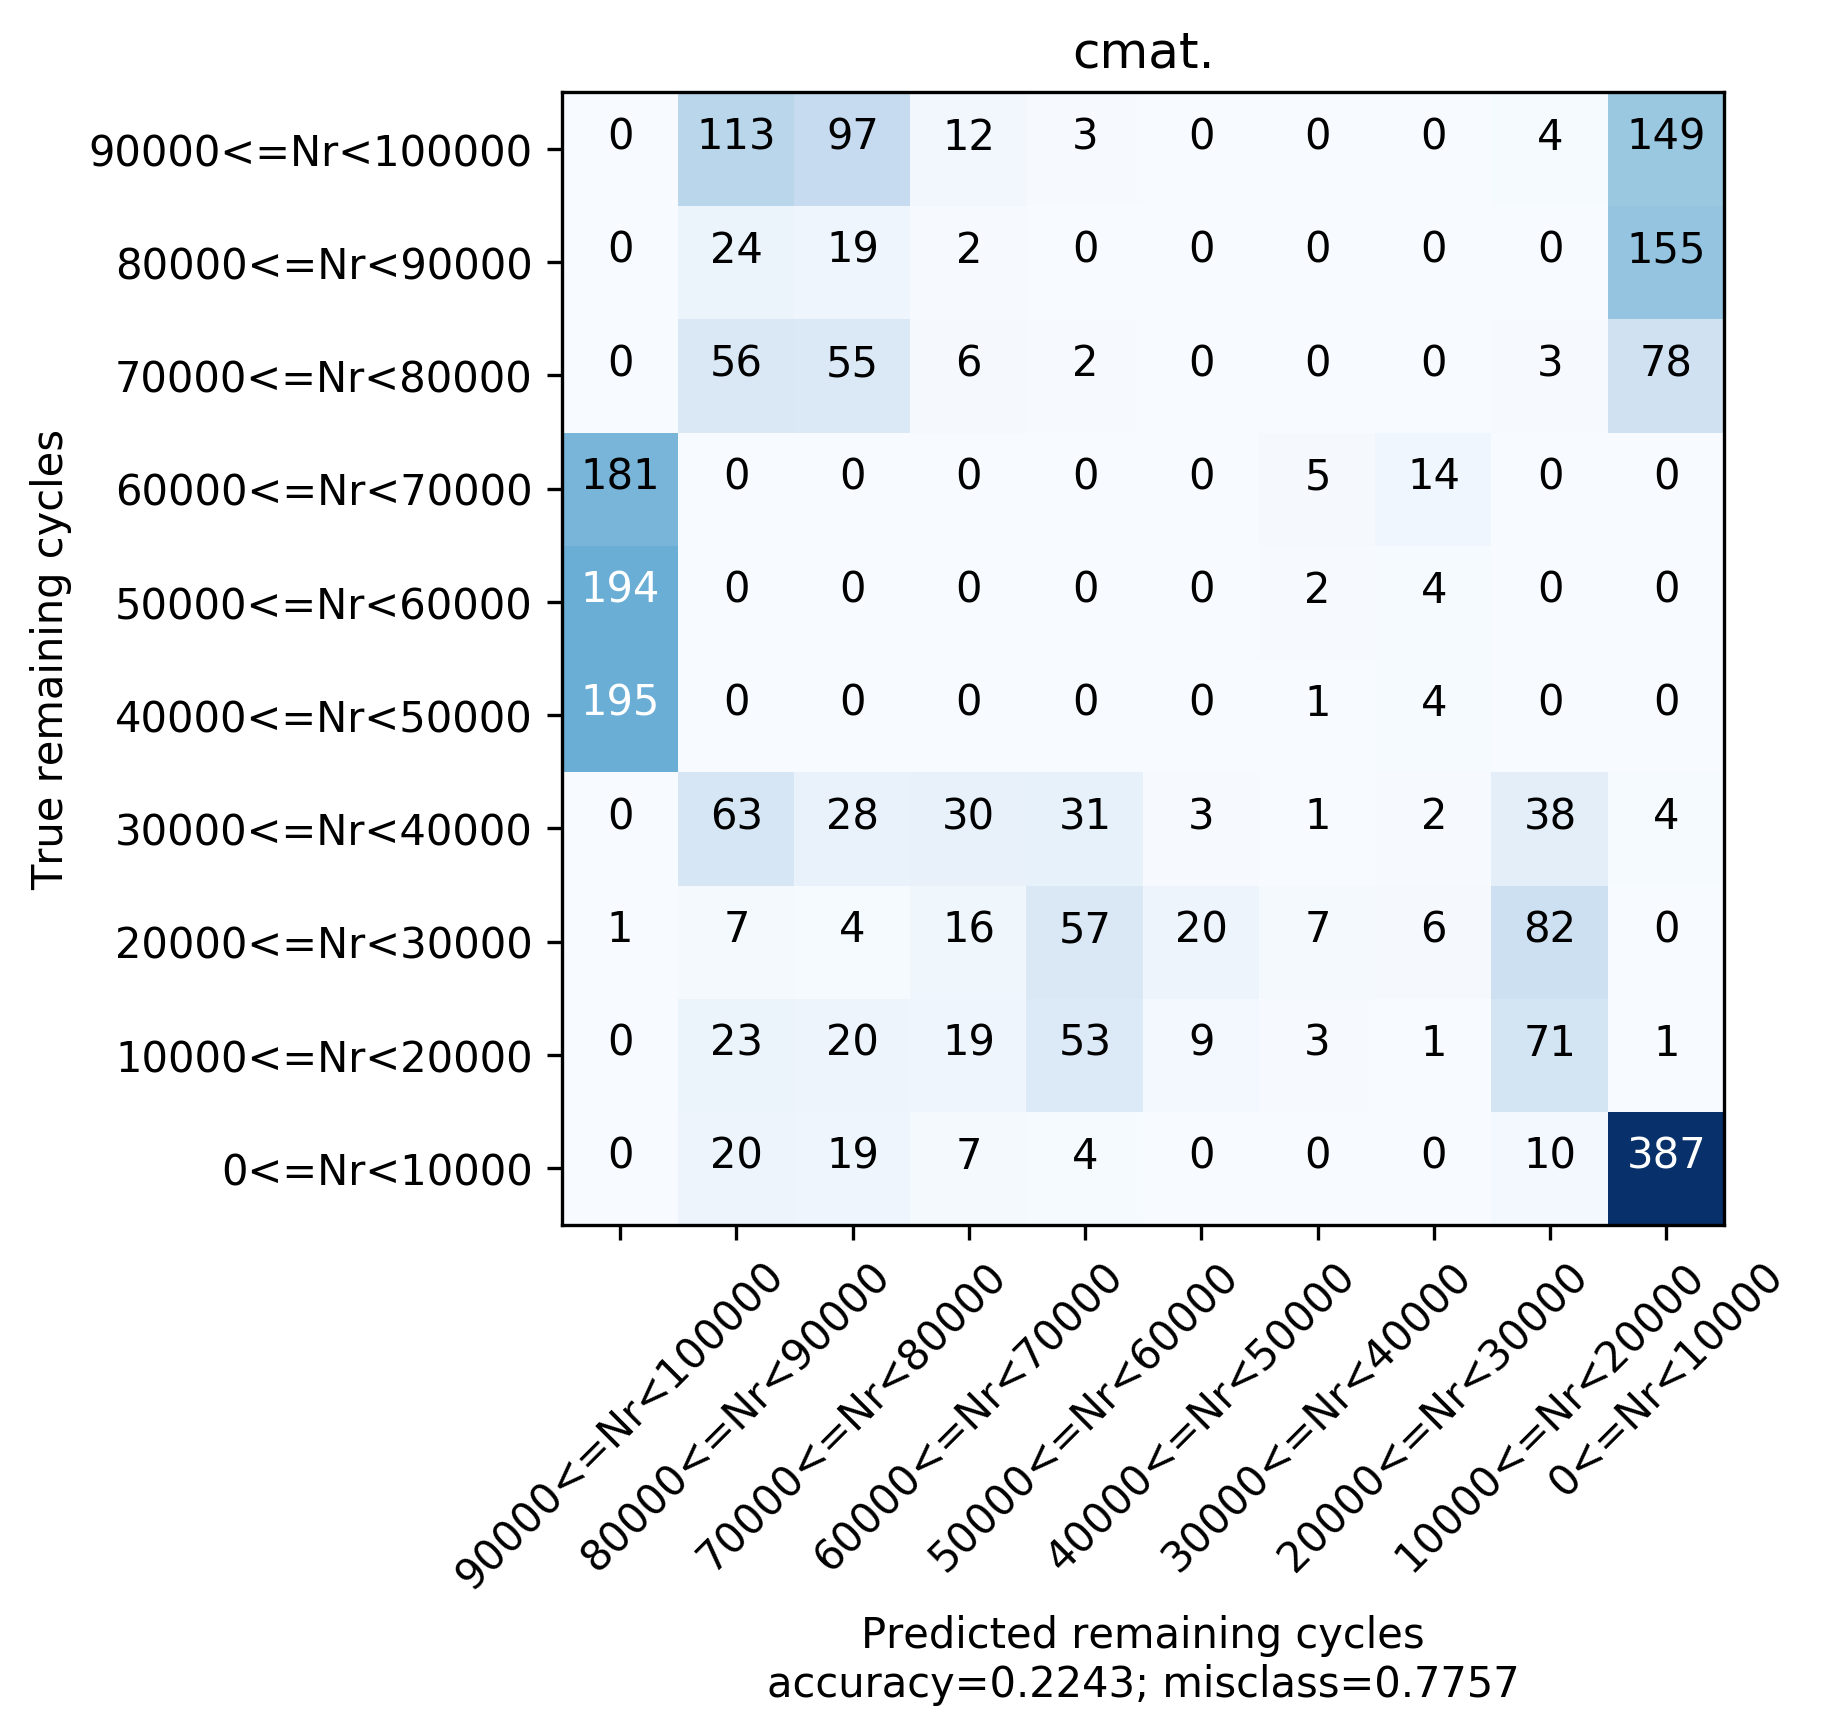

In [42]:
ids_exp = [eid_vector_all == 'VA_1']
yyhat = model.predict(X_all[ids_exp])
cmat = confusion_matrix(np.argmax(Yoh_all[ids_exp],1),np.argmax(yyhat[1],1))
crange = int(150000/15);
target_names = ["%i<=Nr<%i"%((i)*crange,(i+1)*crange) for i in range(cmat.shape[0])]
plot_confusion_matrix(cmat.eval(),target_names = target_names, figsize = (5,5), normalize = False, title = "cmat.")


In [51]:
YstrongOH.shape
eid_vector_strong_vals

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

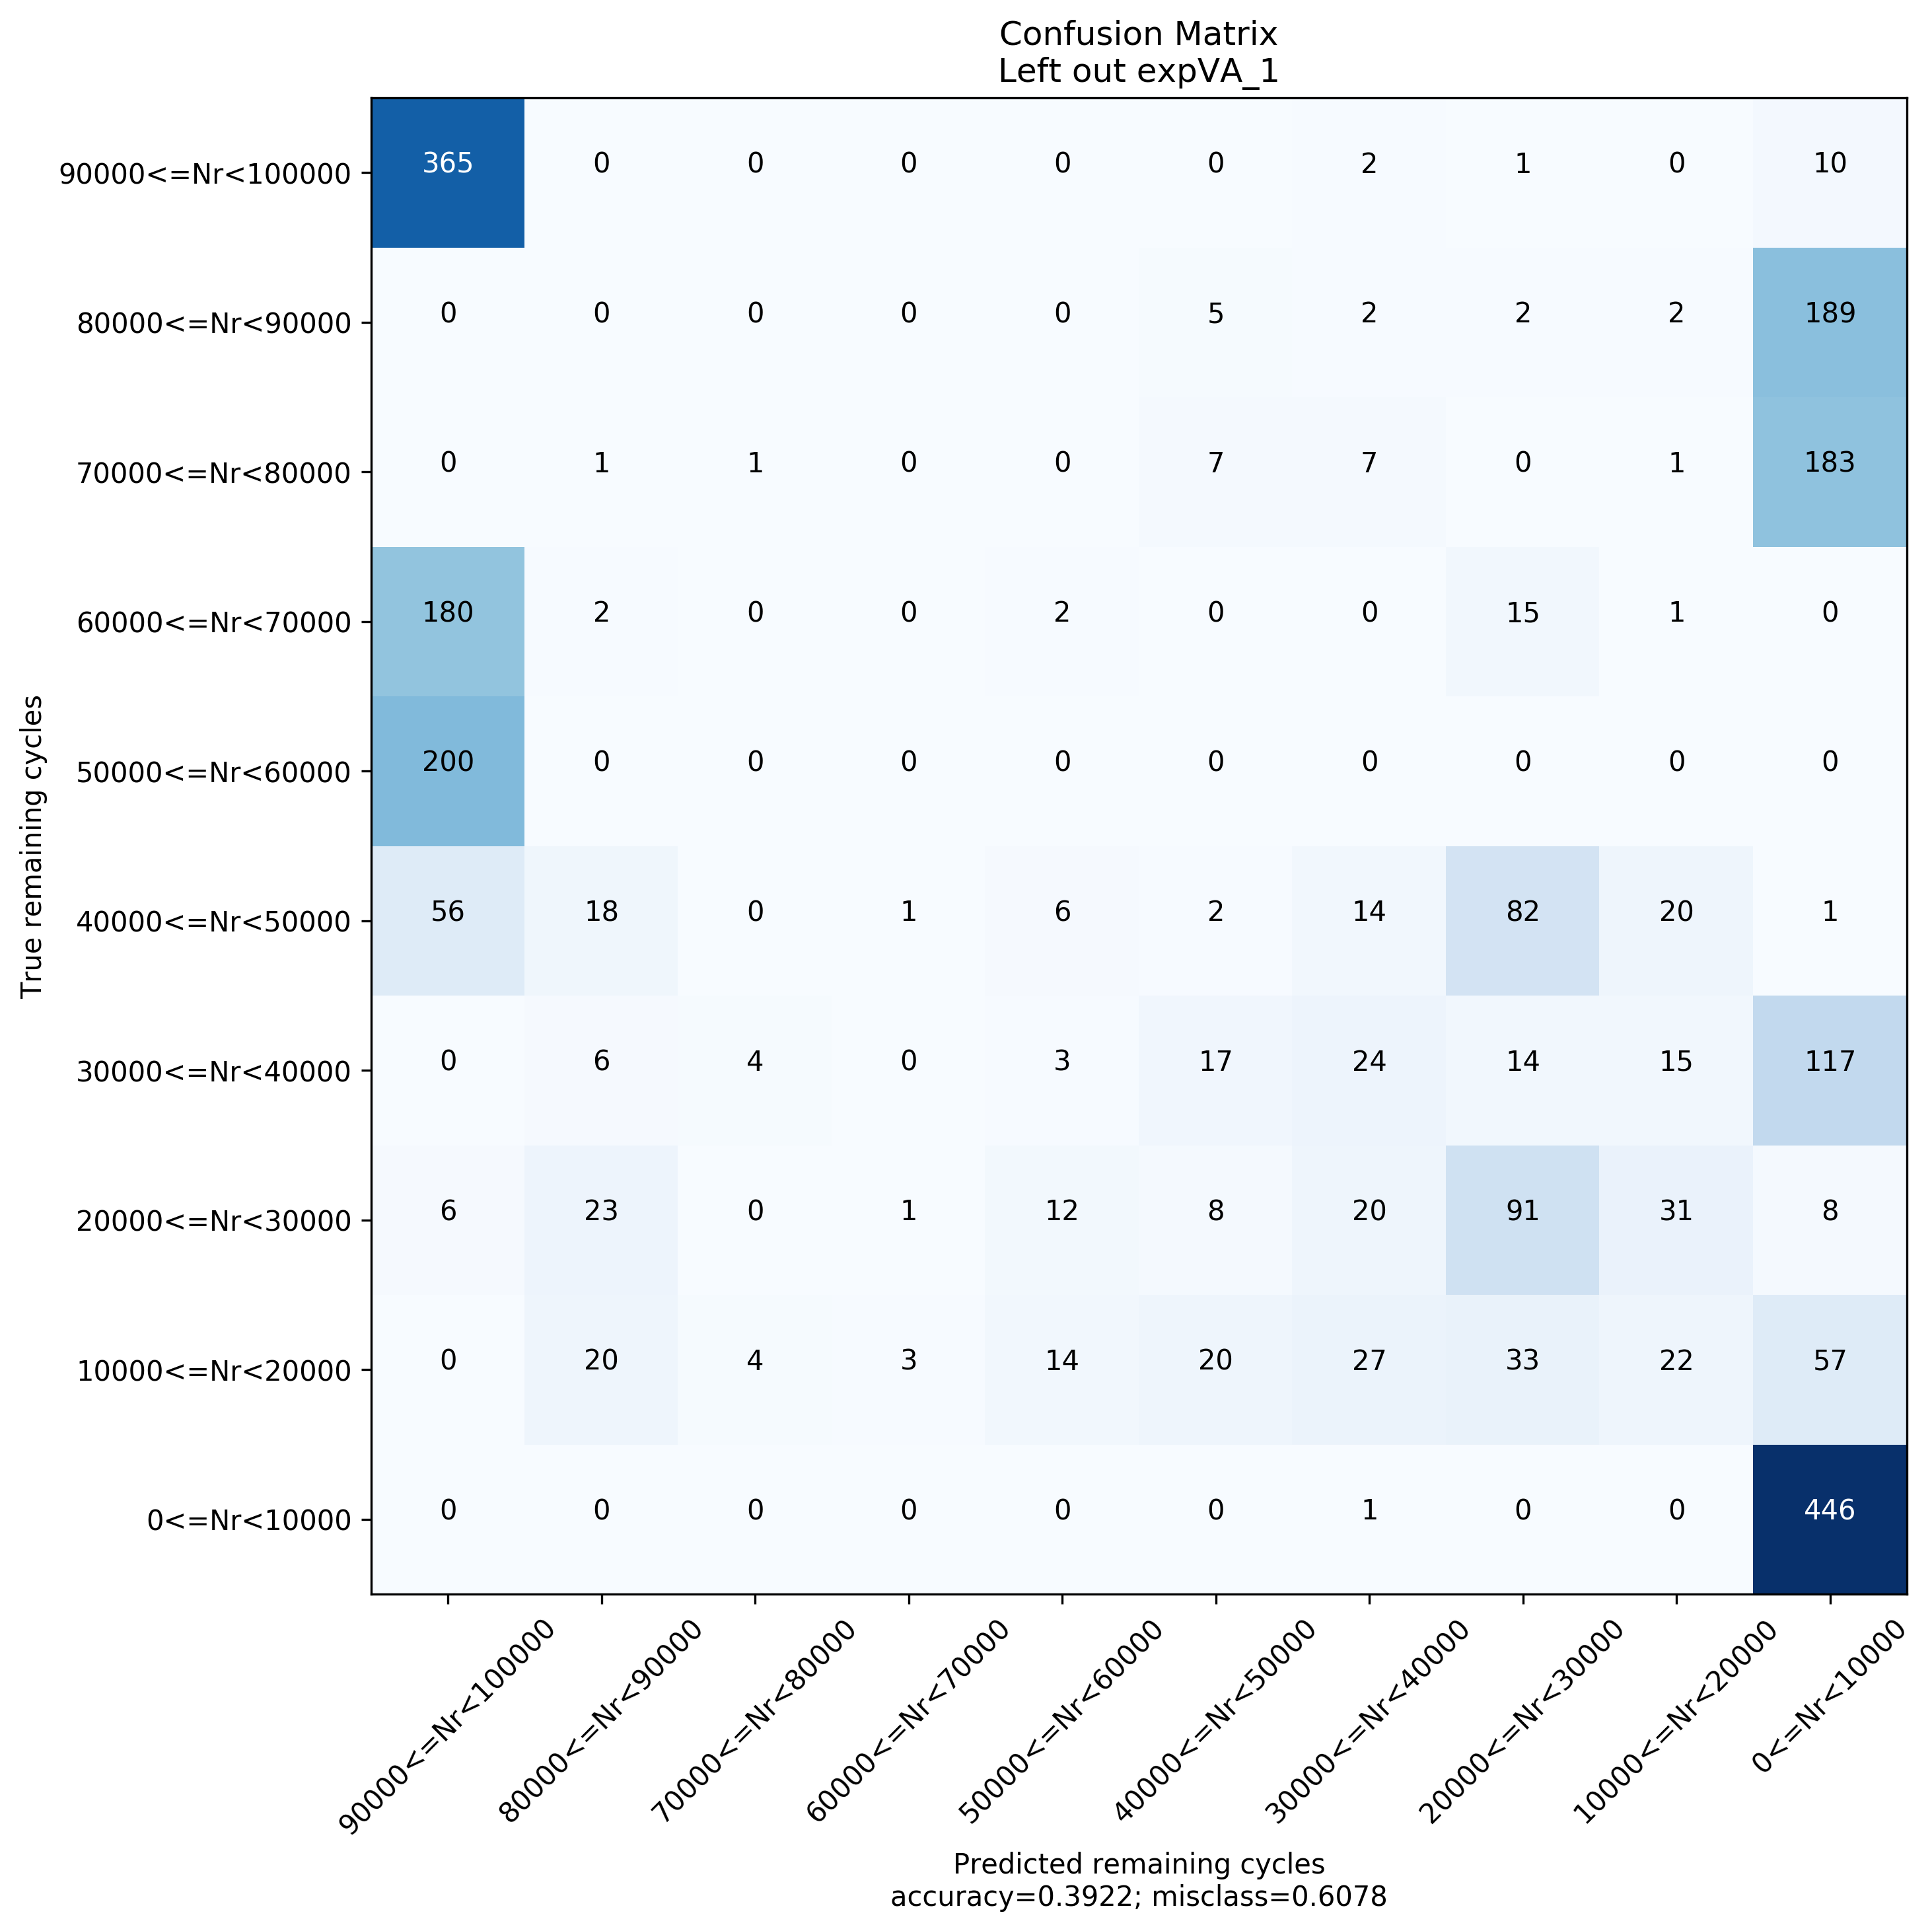

6676/6676 [==============================] - 7s 1ms/sample - loss: 2.3634 - ExpID_loss: 0.9390 - Y_output_loss: 1.9694 - Y_output_top3_acc: 0.5046 - val_loss: 2.2505 - val_ExpID_loss: 0.0000e+00 - val_Y_output_loss: 1.7802 - val_Y_output_top3_acc: 0.5790
Epoch 72/100
6676/6676 [==============================] - 4s 640us/sample - loss: 2.2282 - ExpID_loss: 0.9422 - Y_output_loss: 1.9759 - Y_output_top3_acc: 0.4961 - val_loss: 2.1188 - val_ExpID_loss: 0.0000e+00 - val_Y_output_loss: 1.7789 - val_Y_output_top3_acc: 0.5625
Epoch 73/100
6676/6676 [==============================] - 4s 648us/sample - loss: 2.0994 - ExpID_loss: 0.9445 - Y_output_loss: 1.9736 - Y_output_top3_acc: 0.4993 - val_loss: 1.9936 - val_ExpID_loss: 0.0000e+00 - val_Y_output_loss: 1.7797 - val_Y_output_top3_acc: 0.5604
Epoch 74/100
6676/6676 [==============================] - 4s 636us/sample - loss: 1.9773 - ExpID_loss: 0.9477 - Y_output_loss: 1.9677 - Y_output_top3_acc: 0.5049 - val_loss: 1.8744 - val_ExpID_loss: 0.0000

KeyboardInterrupt: 

In [52]:
epochs = 100; #training_parameters["nepochs"]
batchsize =100;

from tensorflow.math import confusion_matrix
import tensorflow.keras as keras
from tensorflow.keras import layers 
lrate = 0.001


es = keras.callbacks.EarlyStopping(monitor='val_Y_output_loss', mode='min', verbose=1, patience=10, restore_best_weights = True)

class Top3AccStrong(tf.keras.callbacks.Callback):
    def __init__(self):
        self.top3acc_strong = []
    def on_epoch_end(self,epoch,logs = None):
        top3acc = plot_cmatrix_strong_return_top3acc(leave_exp_out, epoch, 0.001,root_folder = "/tmp")
        self.top3acc_strong.append(top3acc)


class InspectActivations(tf.keras.callbacks.Callback):
        
    def __init__(self):
        None
        
    def on_epoch_end(self,epoch,logs = None):
        
        print("Plotting output activation statistics from DN:")
        plot_dn_output_activation_statistics()
        pplot.show()
        pplot.pause(0.1)


def top3_acc(labels, logits):
    return keras.metrics.top_k_categorical_accuracy(labels,logits, k=3)



def plot_confusion():
    cmat = confusion_matrix(np.argmax(Yoh,1),np.argmax(Yhat,1))
    pplot.pcolor(cmat.eval())
    pplot.show()

adv_loss = {"ExpID" : tf.compat.v1.losses.softmax_cross_entropy}
loss_fcn = {"Y_output" :tf.compat.v1.losses.softmax_cross_entropy,
            "ExpID" : lambda y,yhat : tf.compat.v1.losses.softmax_cross_entropy(y,yhat)}

loss_w = {"Y_output": 0.66*3./(3.+15.)*(1-c_loss),"ExpID" : 0.33*15./(3.+15.)*c_loss }

# GOAL: Minimize the useless discriminator while maximizing the useful classifier.

# useful discriminator:
model_opt = keras.optimizers.Adam(learning_rate=lrate);
model.compile(optimizer =  model_opt,
              loss =loss_fcn,
              loss_weights = loss_w,
              metrics = {"Y_output" : top3_acc})

train_in, train_out = [{"timeseries_input": Xtrain},{"Y_output":Ytrain,  "ExpID" : EIDTrain}]
#test_in, test_out = [{"timeseries_input" : Xtest}, {"Y_output" : Ytest, "ExpID" : EIDTest}]
test_in, test_out = [{"timeseries_input" : Xstrong}, {"Y_output" : YstrongOH, "ExpID" : np.zeros([YstrongOH.shape[0],3])}]

history_d = model.fit(train_in, train_out, epochs=epochs,
                     batch_size=batchsize,
                      validation_data = [test_in, test_out],# "Rc_output" :  RemCTest}],
                     callbacks=[es, Top3AccStrong()])#, InspectActivations()]);#, Top3AccStrong()])




In [ ]:
pplot.plot(history_d.history['val_loss'])

In [25]:
pplot.plot((np.argsort(Xpred_strong_hat , 1)[:,-1:]+1) * 10000,'.')

NameError: name 'Xpred_strong_hat' is not defined

In [26]:
Ypred_strong_hat

NameError: name 'Ypred_strong_hat' is not defined

In [27]:
Yelapsed_strong

NameError: name 'Yelapsed_strong' is not defined

In [28]:
#pplot.pcolor(tf.math.softmax(Xpred_strong_hat,axis=1).eval())
smoothing_ = 0.3
conf_thresh_ = 0.5 
shifts_thresh_ = 5;
Yp_ = Yp
Xp_ = Xp
Yelapsed_strong = -Yp_+Yp_[0]
Ypred_strong_seq = Yelapsed_strong[::5];
Xpred_strong_seq = Xp_[::5,:,:]

Ypred_strong_hat = model.predict(Xpred_strong_seq)[1]

def softmax_shifts(elapsed_values, softmax_vals, smoothing = smoothing_, conf_thresh = conf_thresh_, shifts_thresh = shifts_thresh_):
    max_elapsed = 21000;
    
    shift_bins = int(np.floor(elapsed_values / 10000))
    if shift_bins > shifts_thresh:
        softmax_vals = np.ones_like(softmax_vals)
        shift_bins = 0;
        
    #if shift_bins >= 9:
    #    shift_bins = 9;
    
    smoothing = smoothing*np.sum(softmax_vals[:shift_bins])
    
    if np.max(softmax_vals) < conf_thresh :
        softmax_vals = np.ones_like(softmax_vals)
        
        
    if max_elapsed < elapsed_values:
        softmax_vals = np.ones_like(softmax_vals)
        
    #softmax_vals = np.ones_like(softmax_vals)
        
    shifted_softmax_vals = np.hstack([softmax_vals[shift_bins:]+smoothing, np.zeros(shift_bins)*1.])
    shifted_softmax_vals = shifted_softmax_vals / np.sum(shifted_softmax_vals)
    return shifted_softmax_vals

sm_val = tf.math.softmax(Ypred_strong_hat).eval()

def predict_at_index(prediction_index,smoothing = smoothing_, conf_thresh=conf_thresh_, shifts_thresh = shifts_thresh_):
    all_res = [];
    tmps = [];
    res = np.ones_like(sm_val[0])
    res = res / np.sum(res)
    
    for ii in range(0, prediction_index):
        elapsed_for_current_prediction = Ypred_strong_seq[prediction_index] - Ypred_strong_seq[ii] 
        #print(elapsed_for_current_prediction)
        tmp  =softmax_shifts(elapsed_for_current_prediction, sm_val[ii], smoothing =smoothing, conf_thresh=conf_thresh)
        
        #tmp = softmax_shifts(0,sm_val[ii])
        tmp = tmp / np.sum(tmp)
        
        res *= tmp
        res = res / np.sum(res)
        all_res.append(res)
        
        #res = res/ np.sum(res)
    return res, all_res

def predict_all(smoothing = 0.1, conf_thresh = 0.5, skip = 1):
    accum_softmax_predictions = [];
    for ii in range(0, len( Ypred_strong_seq)-1,skip):
        pp, all_preds = predict_at_index(ii, smoothing = smoothing, conf_thresh=conf_thresh)
        accum_softmax_predictions.append(pp)
    return np.vstack(accum_softmax_predictions)
    
res,b = predict_at_index(len(Ypred_strong_seq)-150, smoothing=10,conf_thresh=0.5, shifts_thresh=5)
res,b = predict_at_index(len(Ypred_strong_seq)-1, smoothing=0.1,conf_thresh=0.5, shifts_thresh=5)
#res,b = predict_at_index(242)
#res,b = predict_at_index(100)
#pplot.pcolor(np.vstack(b).T)

res = predict_all(smoothing = 0.1, conf_thresh = 0.6)
pplot.pcolor(res.T)
#pplot.pcolor(res)
#for kk in range(20, len(Ypred_strong_seq) , 100):
#   a,b,c = predict_at_index(kk - 1)
#   pplot.pcolor(np.vstack(b).T)
#   pplot.show()

NameError: name 'Yp' is not defined

In [29]:

pplot.plot(np.argmax(res,1)*10000, np.max(Yp)-Ypred_strong_seq[::1][:-1],'.')
pplot.xlabel("predicted")
pplot.ylabel("true")


NameError: name 'res' is not defined

### What was asked from Eleni (almost)
Eleni asked for evaluation of cycles from the first one. This is difficult to achieve due to resource constraints (not enough RAM to process dataset) and pre-processing (bad outliers will cause NaNs etc). Instead, 300k cycles from end are processed. It is expected that prediction will be bad before 300k cycles from end (while trained for 100k cycles from end).

In [30]:
## load the larger stage-2 dataset.
del data
data_orig = load_hilti_fatigue_data(keep_from_end=  300000,leave_exp_out="None",stage_2_from_disk=True, nclasses = 30, user_normalization = static_normalization)
#data = load_hilti_fatigue_data(keep_from_end=  300000,leave_exp_out="None",stage_2_from_disk=True, nclasses = 30)


proc:1
proc:2
proc:3
proc:4


In [32]:
#[X_all_large,Y_all_large,Yoh_all_large, eid_vector_all_large] = data_orig['training_instances']
[X_all_large,Y_all_large,Yoh_all_large, eid_vector_all_large] = [X_all_0,Y_all_0,Yoh_all_0, eid_vector_all_0] 


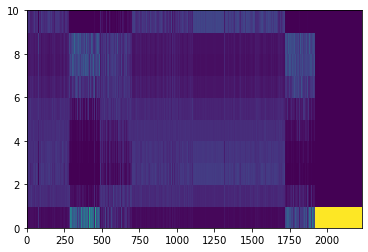

In [37]:
#pplot.plot(Y_all_large)
Xp  = X_all_large[eid_vector_all_large=='VA_3']
Yp = Y_all_large[eid_vector_all_large=='VA_3']
preds = model.predict(Xp, batch_size=100)
pplot.pcolor(tf.math.softmax(preds[1],axis = 1).eval().T)
pplot.show()


In [38]:
np.sum(np.abs(np.argmax(preds_0[1],1) - np.argmax(preds[1],1)))

NameError: name 'preds_0' is not defined

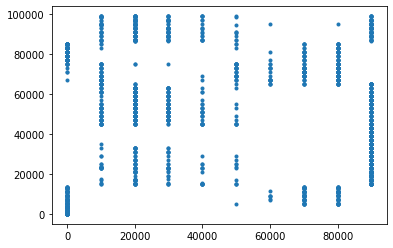

In [40]:
pplot.plot(np.argmax(preds[1],1)*10000,Yp,'.')

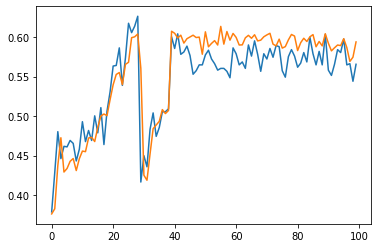

In [41]:
pplot.plot(history_d.history['val_Y_output_top3_acc'])
pplot.plot(history_d.history['Y_output_top3_acc'])

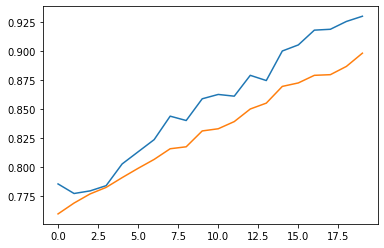

In [145]:
pplot.plot(history_d.history['val_Y_output_top3_acc'])
pplot.plot(history_d.history['Y_output_top3_acc'])

In [364]:
model.predict(Xtrain[0:10])

[array([[-0.34837586,  0.00368509, -0.1805424 ],
        [-0.43319124, -0.05686785, -0.11221661],
        [-0.09013592, -0.39151192, -0.44847643],
        [-0.35685885, -0.11942682, -0.10697539],
        [ 0.07004528, -0.19214043,  0.04627136],
        [ 0.16331759, -0.30544516, -0.01577613],
        [-0.49275243, -0.15465611, -0.04446436],
        [ 0.00626324, -0.01381621, -0.18764408],
        [-0.01066042,  0.00174898, -0.17184691],
        [-0.45257336, -0.14852586, -0.06065439]], dtype=float32),
 array([[-3.67977810e+00, -2.78612566e+00, -2.36756516e+00,
         -7.98950315e-01,  5.24726689e-01,  2.14148641e+00,
          2.64324450e+00,  2.86070108e+00,  2.88678432e+00,
          1.99527228e+00],
        [-3.83714938e+00, -2.94400740e+00, -2.50958133e+00,
         -8.72210145e-01,  5.38383782e-01,  2.28750753e+00,
          2.88971353e+00,  3.12041807e+00,  3.15353942e+00,
          2.11398339e+00],
        [ 9.36346970e+01,  8.81310806e+01,  8.22106400e+01,
          5.1498554

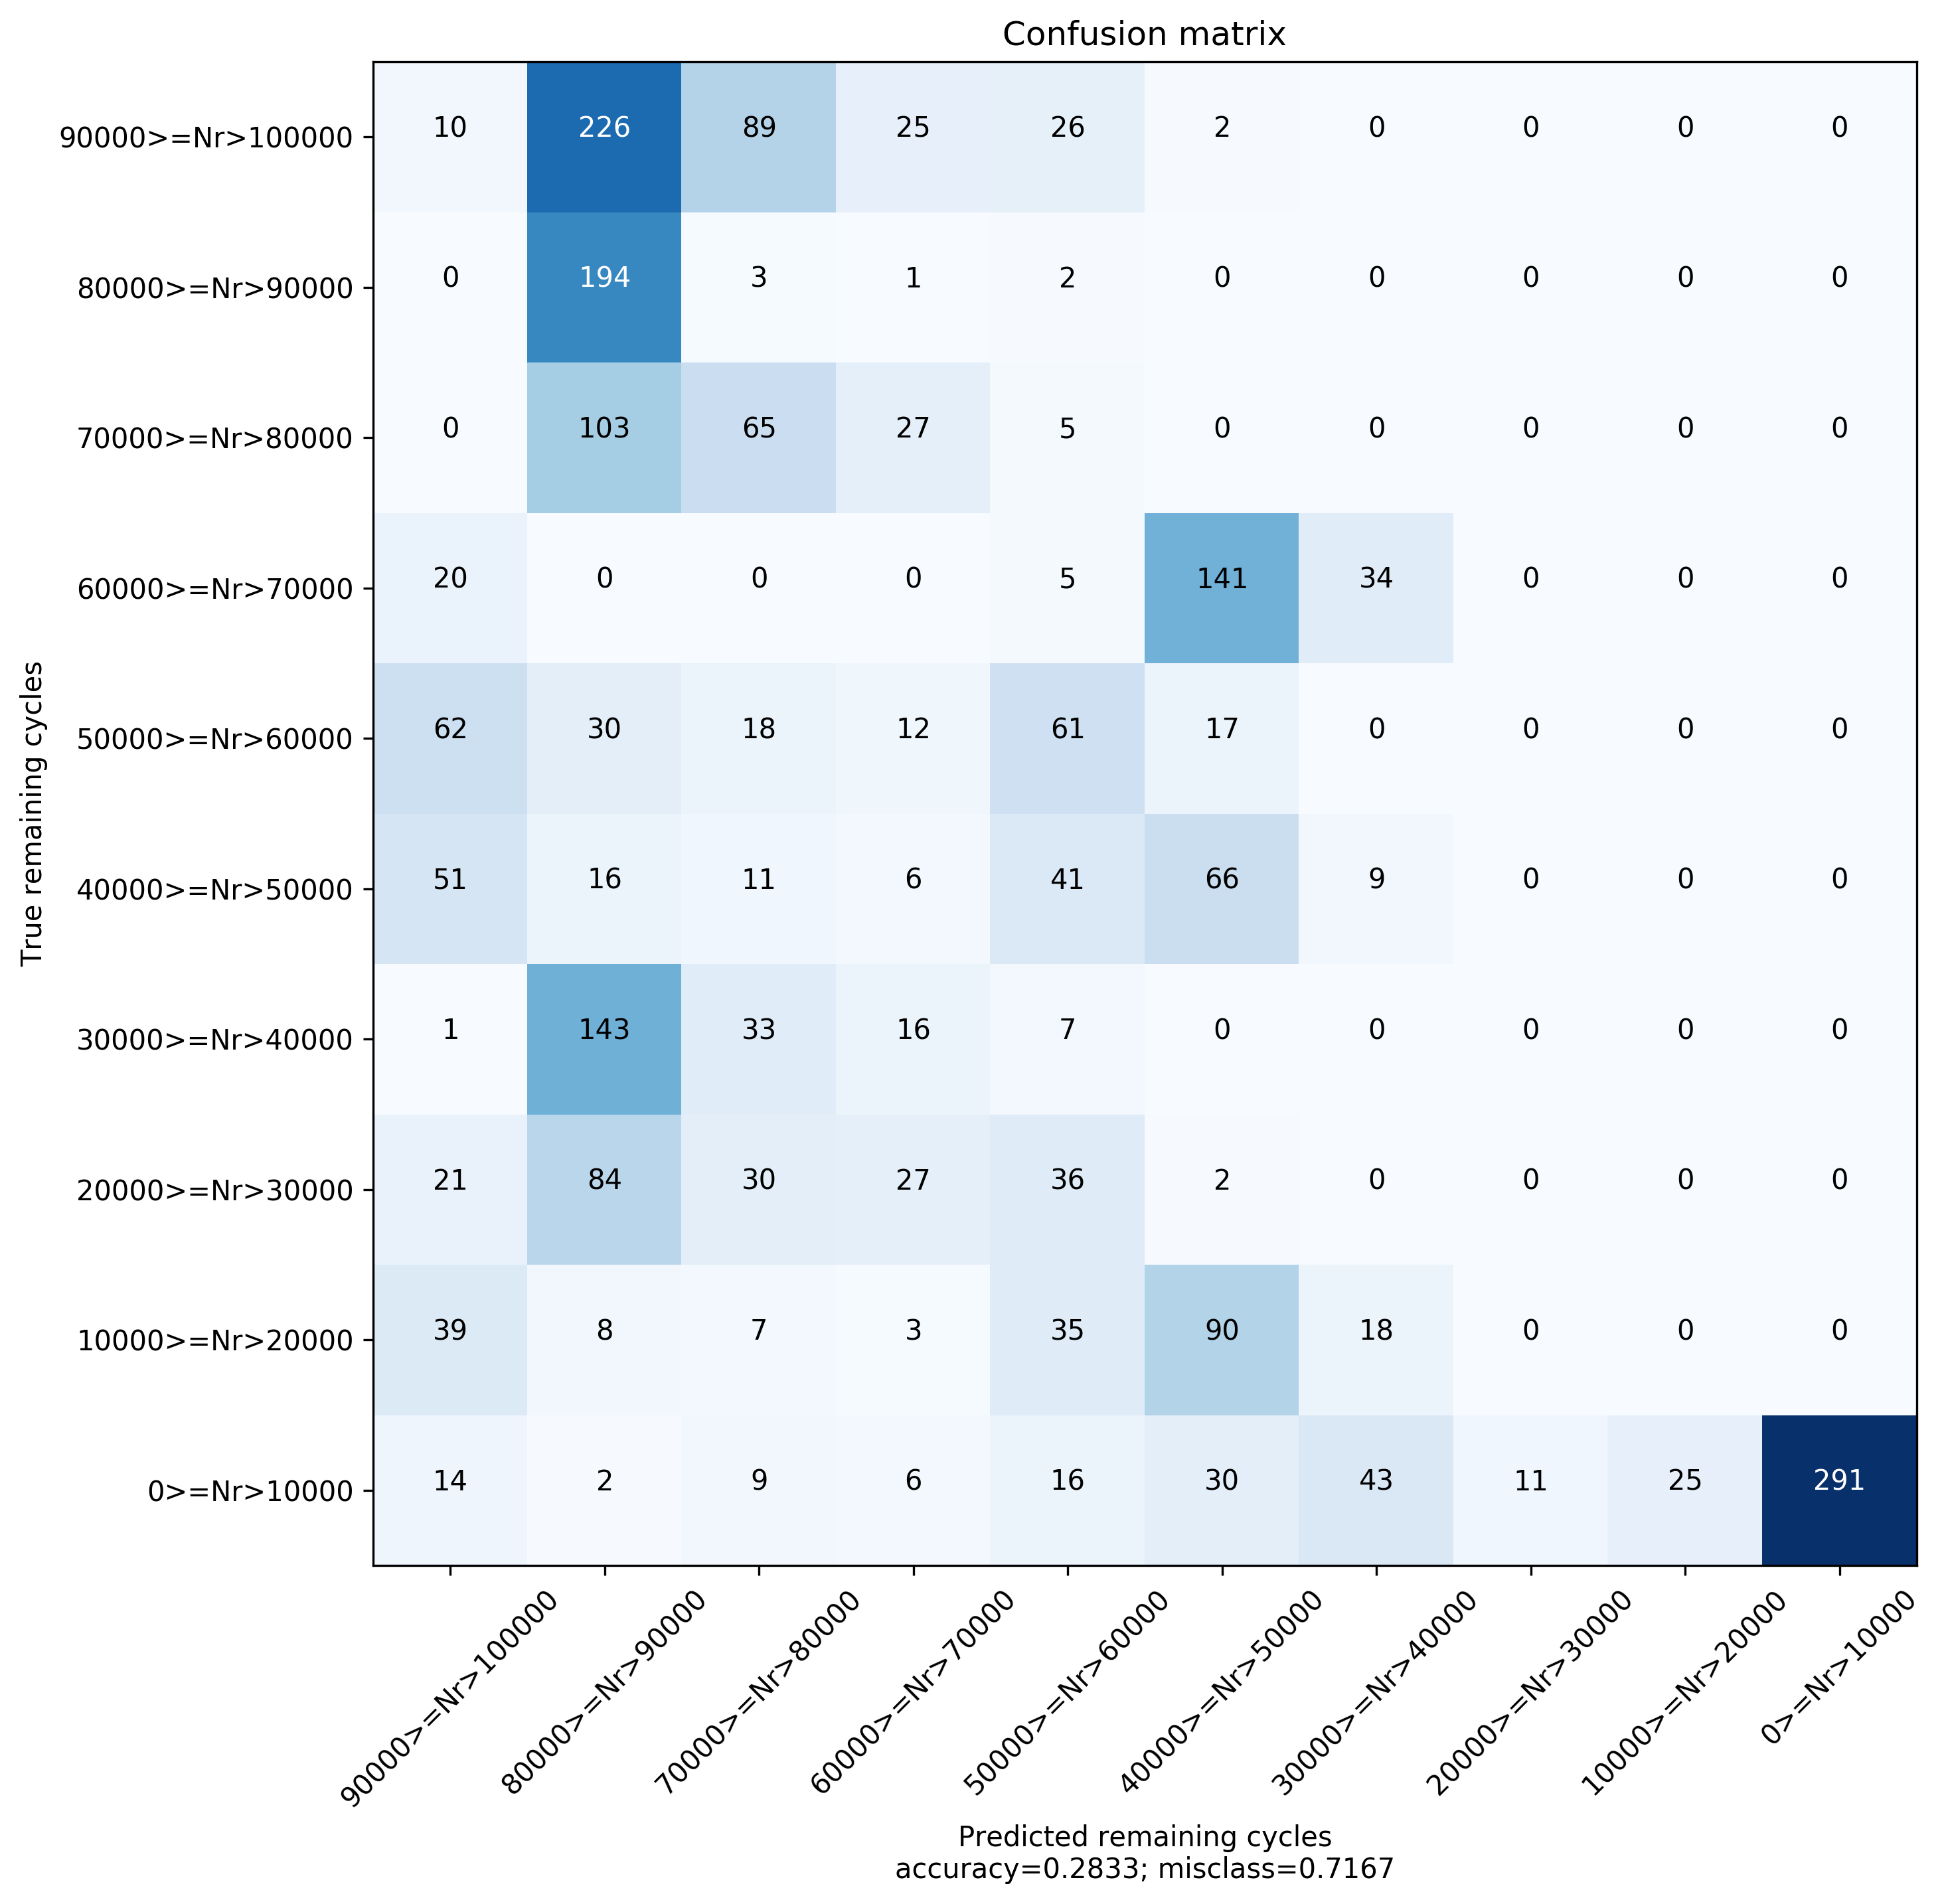

In [366]:
yhat = model.predict(Xstrong, batch_size=100)[1]
if tf.executing_eagerly():
    cmat = tf.confusion_matrix(tf.argmax(YstrongOH,1), tf.argmax(yhat,1)).numpy()
else:
    cmat = tf.confusion_matrix(tf.argmax(YstrongOH,1), tf.argmax(yhat,1)).eval(session = tf.keras.backend.get_session())

crange = int(150000/15);
target_names = ["%i>=Nr>%i"%((i)*crange,(i+1)*crange) for i in range(int(cmat.shape[0]))]
plot_confusion_matrix(cmat, target_names = target_names)

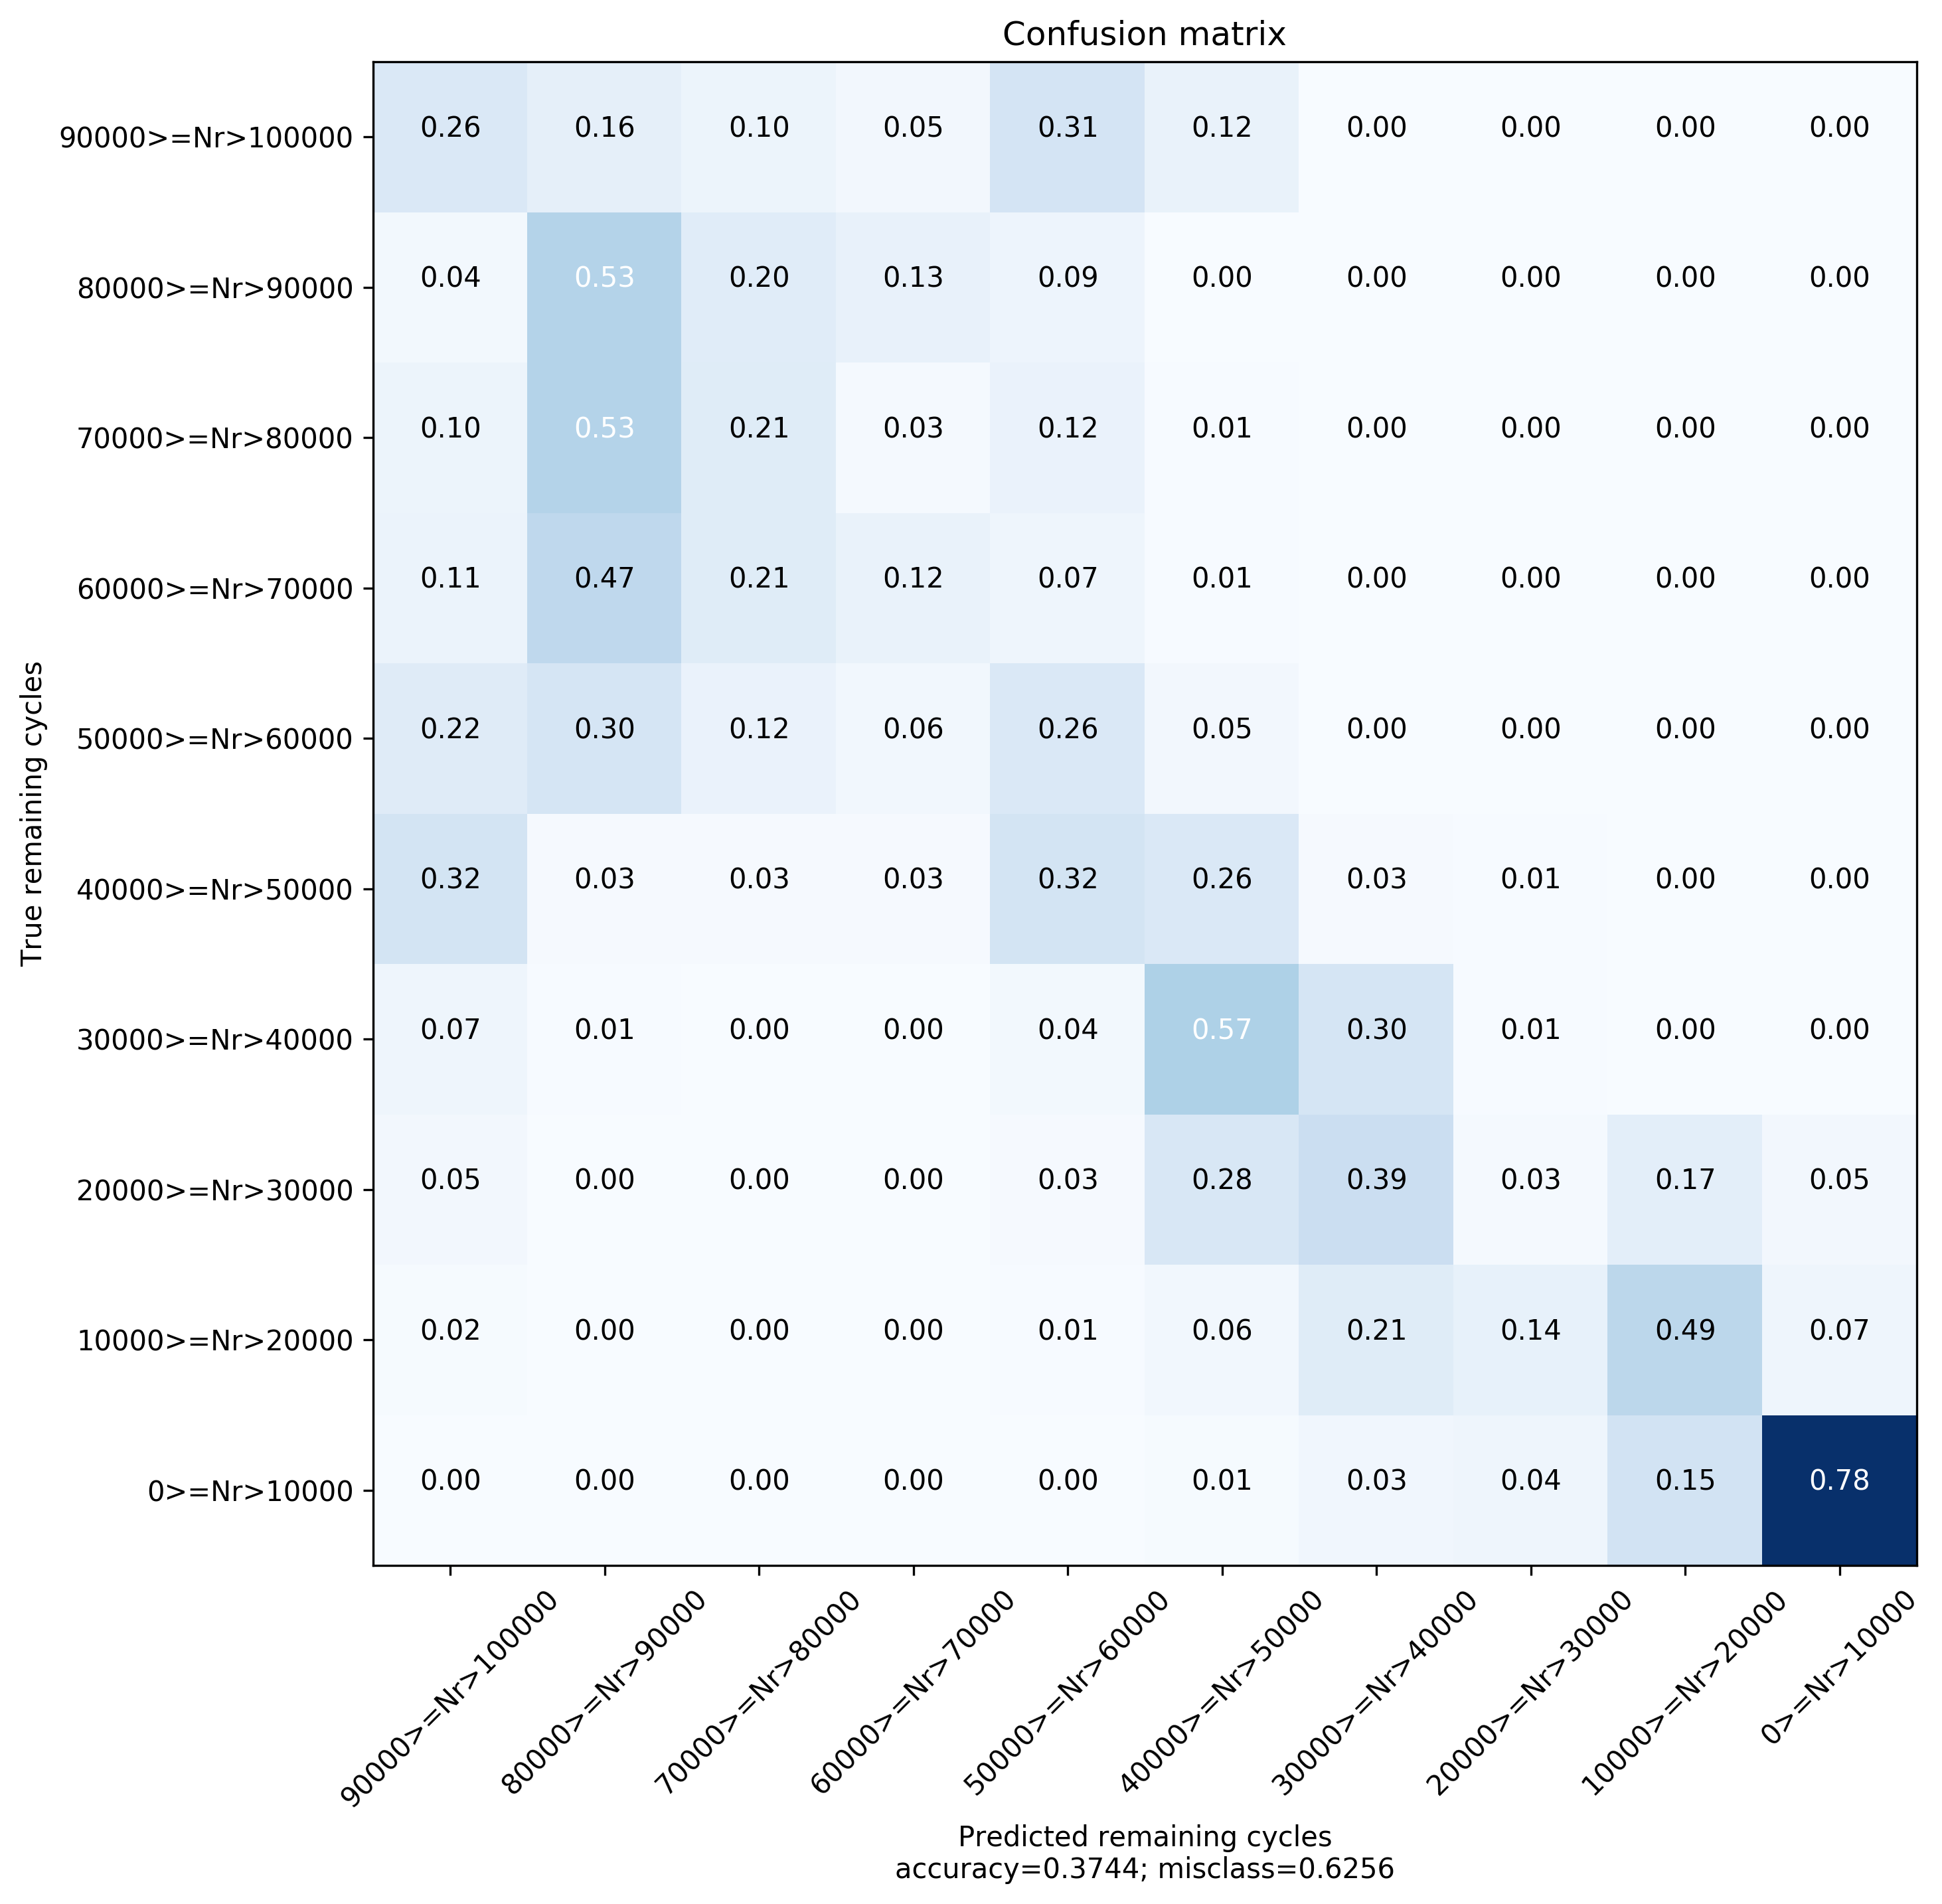

In [369]:
yhat = model.predict(Xtest, batch_size=100)[1]
crange = 10000
if tf.executing_eagerly():
    cmat = tf.confusion_matrix(tf.argmax(Ytest,1), tf.argmax(yhat,1)).numpy()
else:
    cmat = tf.confusion_matrix(tf.argmax(Ytest,1), tf.argmax(yhat,1)).eval(session = tf.keras.backend.get_session())
target_names = ["%i>=Nr>%i"%((i)*crange,(i+1)*crange) for i in range(int(cmat.shape[0]))]
plot_confusion_matrix(cmat, target_names = target_names, normalize=True)

In [148]:

#model.save("trained_model_VA2/model_")
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
timeseries_input (InputLayer)   [(None, 1500, 6)]    0                                            
__________________________________________________________________________________________________
DN_DN1_C1D (Conv1D)             (None, 1500, 20)     140         timeseries_input[0][0]           
__________________________________________________________________________________________________
DN_DN1_idx_0 (Sequential)       (None, 1500, 20)     2440        DN_DN1_C1D[0][0]                 
__________________________________________________________________________________________________
DN_DN1_idx_1 (Sequential)       (None, 1500, 20)     2440        DN_DN1_idx_0[0][0]               
                                                                 DN_DN1_C1D[0][0]           

In [26]:
from tensorflow_probability import layers


In [8]:
import os
import json

desc_str = make_network_description_experiments_A(**experiment_parametrization)
results_dir_name = os.path.join("Experiments_A",desc_str);
try:
    results_dir = os.mkdir(results_dir_name)
except:
    None
save_path_losses = os.path.join(results_dir_name,"losses");
save_path_json = os.path.join(results_dir_name,"json");

pd.DataFrame(history_d.history).to_csv(save_path_losses)

with open(save_path_json,'w') as f:
    f.write(json.dumps(experiment_parametrization))


NameError: name 'pd' is not defined

In [122]:
res = model.predict(Xtest, batch_size = 100)
vv = top3_acc(Ytest,res[1])


(array([1199.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1725.]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32), <a list of 10 Patch objects>)

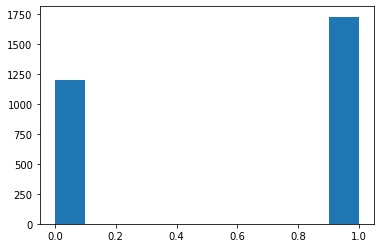

In [126]:
pplot.hist(vv.eval())

In [ ]:
cmat = confusion_matrix

In [16]:
res = model(Xstrong)
vv = top3_acc(YstrongOH, res[1]).eval(session = tf.keras.backend.get_session())

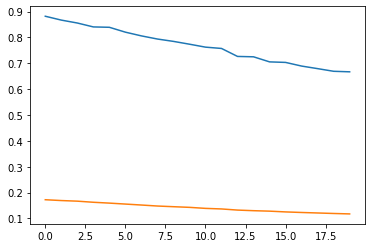

In [149]:
pplot.plot(history_d.history["val_ExpID_loss"])
pplot.plot(history_d.history["val_loss"])

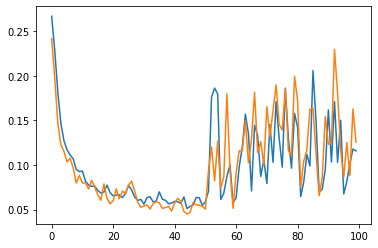

In [29]:
#pplot.pcolor(cmat.eval(session = tf.keras.backend.get_session())**0.15)
pplot.plot(history_d.history["loss"])
pplot.plot(history_d.history["val_loss"])

In [10]:
#pplot.plot(history_d.history['loss'])
#pplot.plot(history_d.history['loss'])
import pandas as pd
dd = pd.DataFrame(history_d.history)
dd.to_csv("/tmp/test")

In [33]:
n_resampled = 300
n_cycles_per_sub_block = 5;
def make_data_per_block(x):
    # This loses some cycles from the end.
    n_stop_idx = x.shape[0] - (x.shape[0] % (n_resampled*n_cycles_per_sub_block))
    x = x[0:n_stop_idx]
    
    n_cycles_in_block = int(x.shape[0]/ n_resampled)
    shape_ = [n_cycles_in_block,int(x.shape[0]/n_cycles_in_block)]
    
    tangent_stiffness = x['KraftQ']/(x['WegQ']**0.15+ 0.1)
    tangent_stiffness = tangent_stiffness.values.reshape(shape_)
    f = x['KraftQ'].values.reshape(shape_)
    u = x['WegQ'].values.reshape(shape_)
    kdot = x['Kdot'].values.reshape(shape_)
    accel = x['AccelQ'].values.reshape(shape_)
    wdot = x['Wdot'].values.reshape(shape_)
    accel = accel - np.mean(accel)
    vals_dat = np.dstack([tangent_stiffness, f, u, accel, kdot, wdot])
    vals_dat = vals_dat.reshape([-1,n_cycles_per_sub_block*n_resampled,vals_dat.shape[-1]])

    get_scalar = lambda scname, x : x[scname].values.reshape(shape_).reshape([-1,n_cycles_per_sub_block*300])[:,0]
    
    rem_c_dat = get_scalar('RemCycles', x)
    #rem_c_dat = rem_c_dat.reshape([-1, n_cycles_per_sub_block])
    
    eid = get_scalar('ExpId',x)
    
    return vals_dat, rem_c_dat, eid

training_data = d.groupby(["ExpId","BlockId"]).apply(make_data_per_block)


X = np.vstack([v[0] for v in training_data.values])
Y = np.concatenate([v[1] for v in training_data.values])
Eid = np.concatenate([v[2] for v in training_data.values])
Yoh = digitize(Y, -1, np.max(Y)+1, 20)
print(X.shape)

<tf.Tensor 'average_pooling1d/Identity:0' shape=(?, 480, 12) dtype=float32>

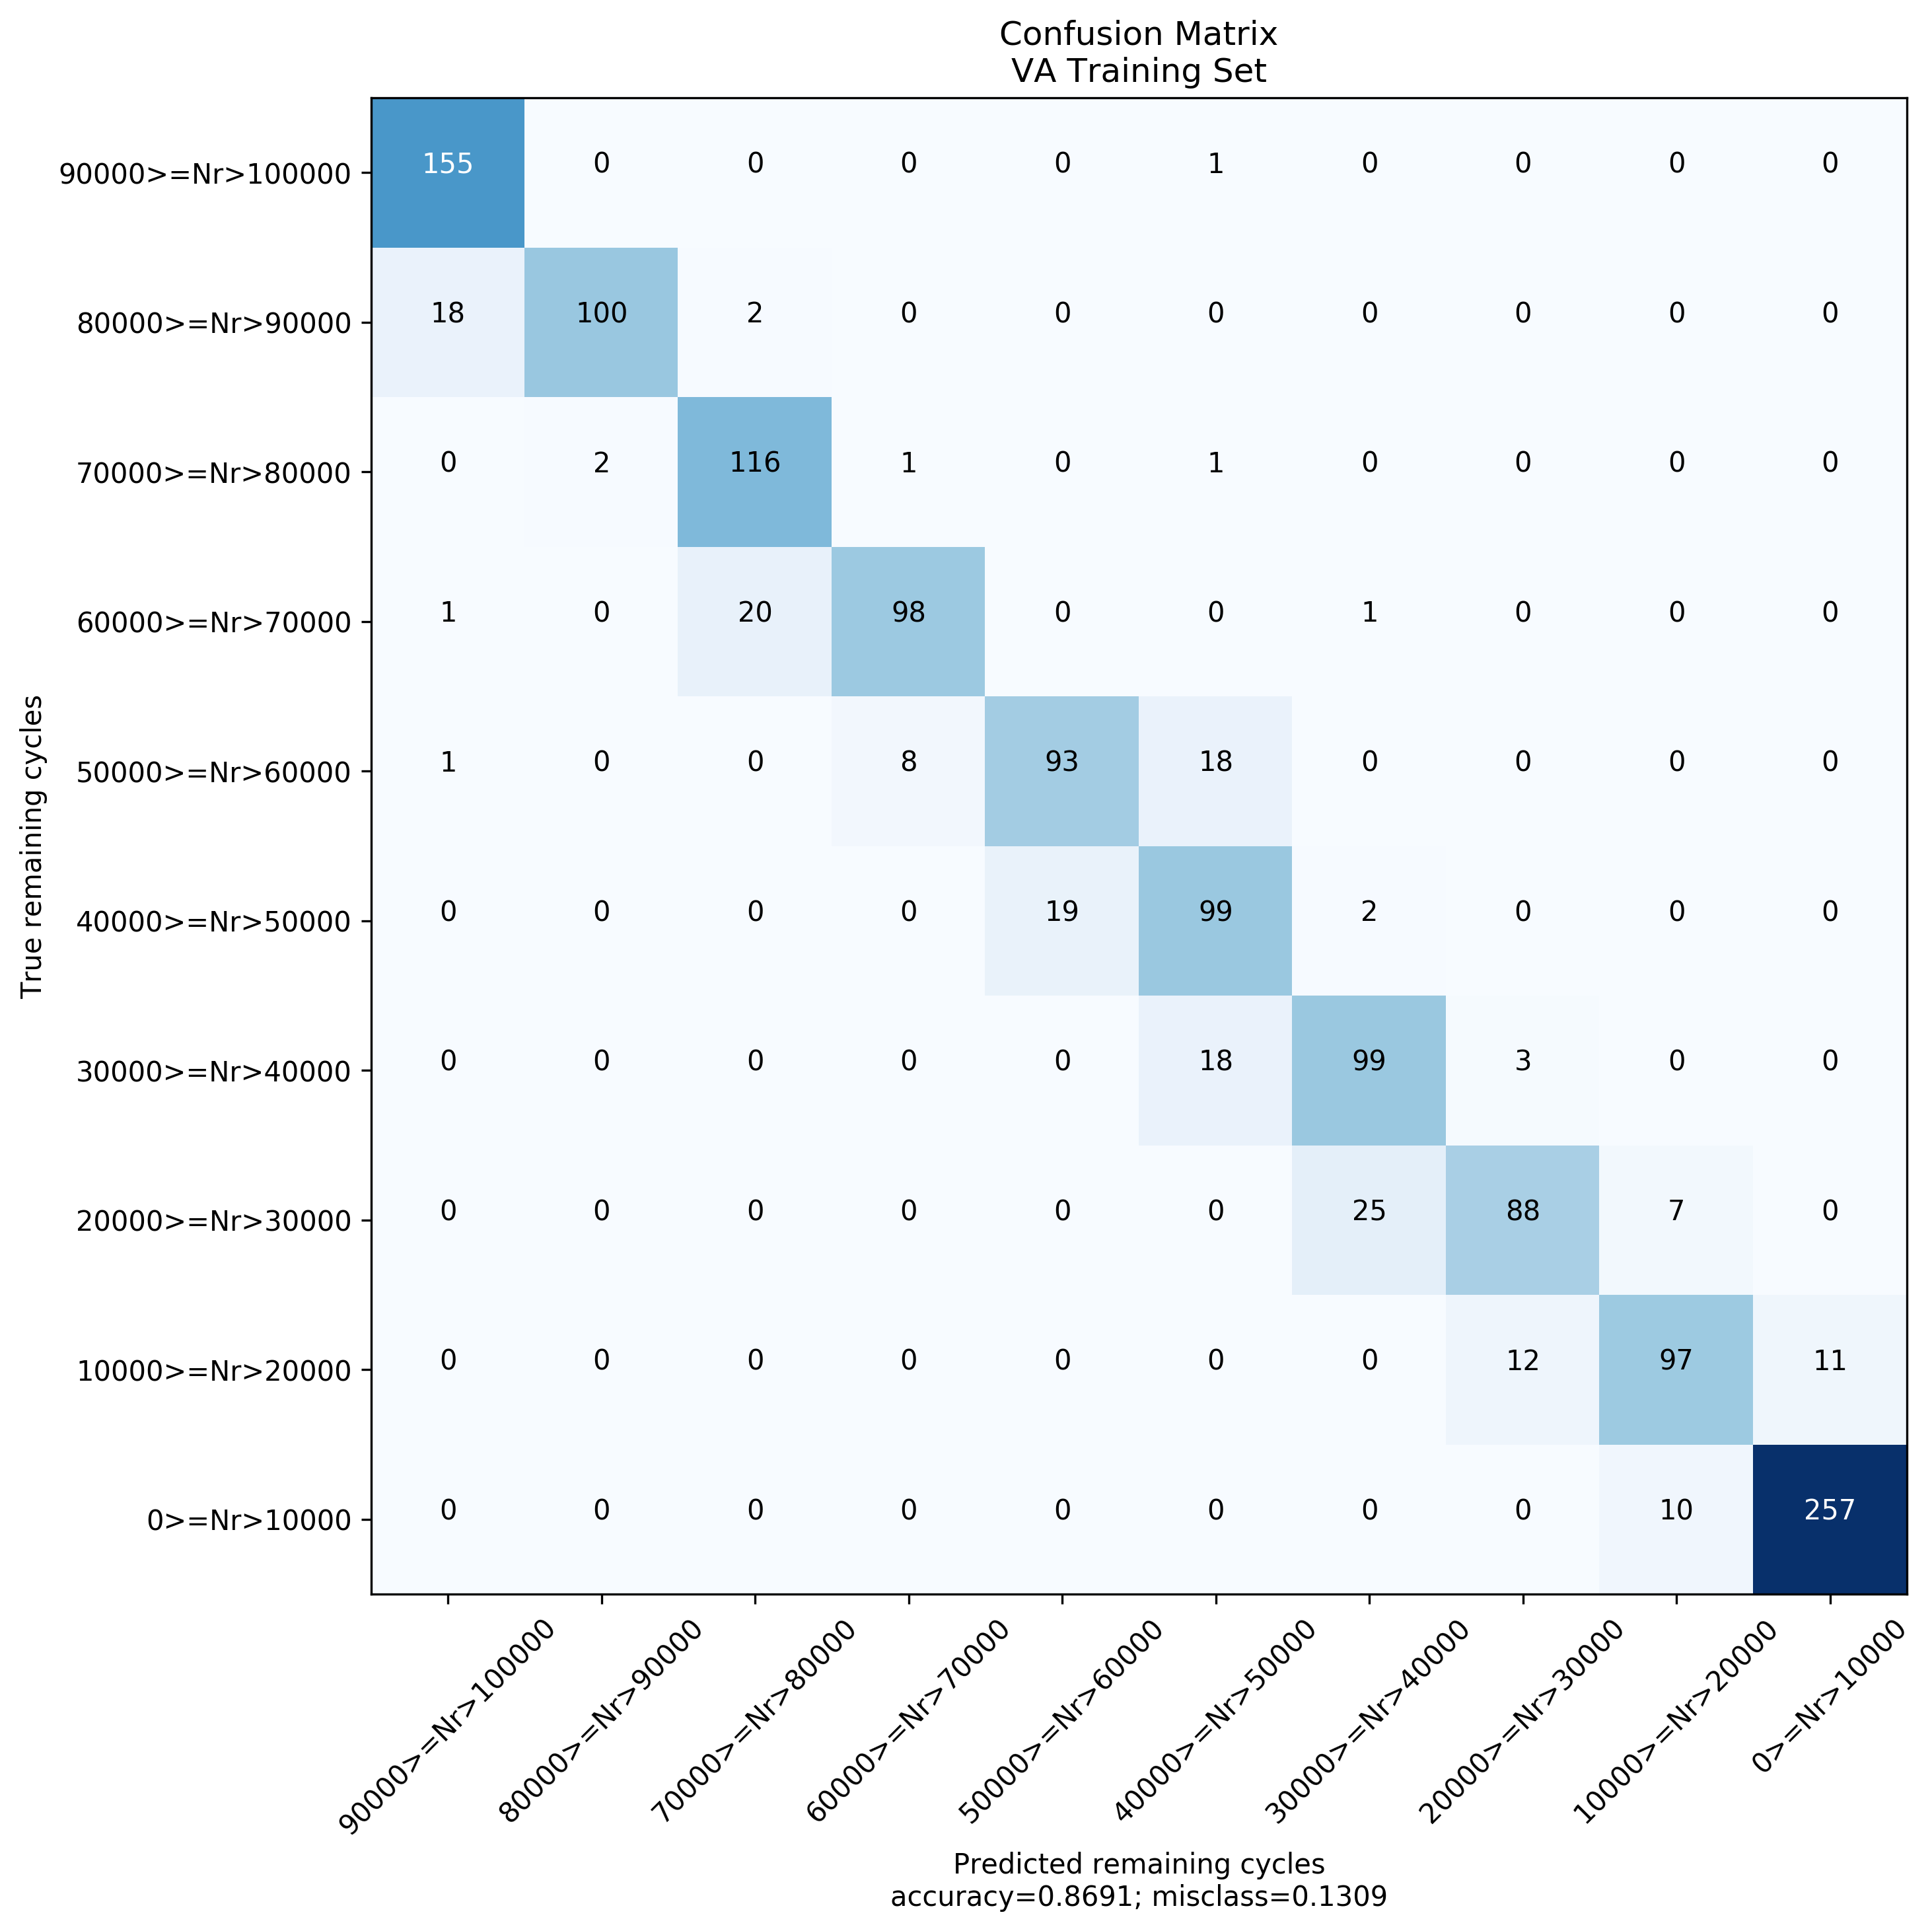

In [31]:
yyhat = model.predict(Xtest)
cmat = confusion_matrix(np.argmax(Ytest,1),np.argmax(yyhat[1],1))
#cmat = cmat[0:-1,0:-1]
crange = int(150000/15);
target_names = ["%i>=Nr>%i"%((i)*crange,(i+1)*crange) for i in range(cmat.shape[0])]
plot_confusion_matrix(cmat.eval(session = keras.backend.get_session()),
                      target_names = target_names , figsize = (10,10), normalize= False, title = "Confusion Matrix\nVA Training Set")


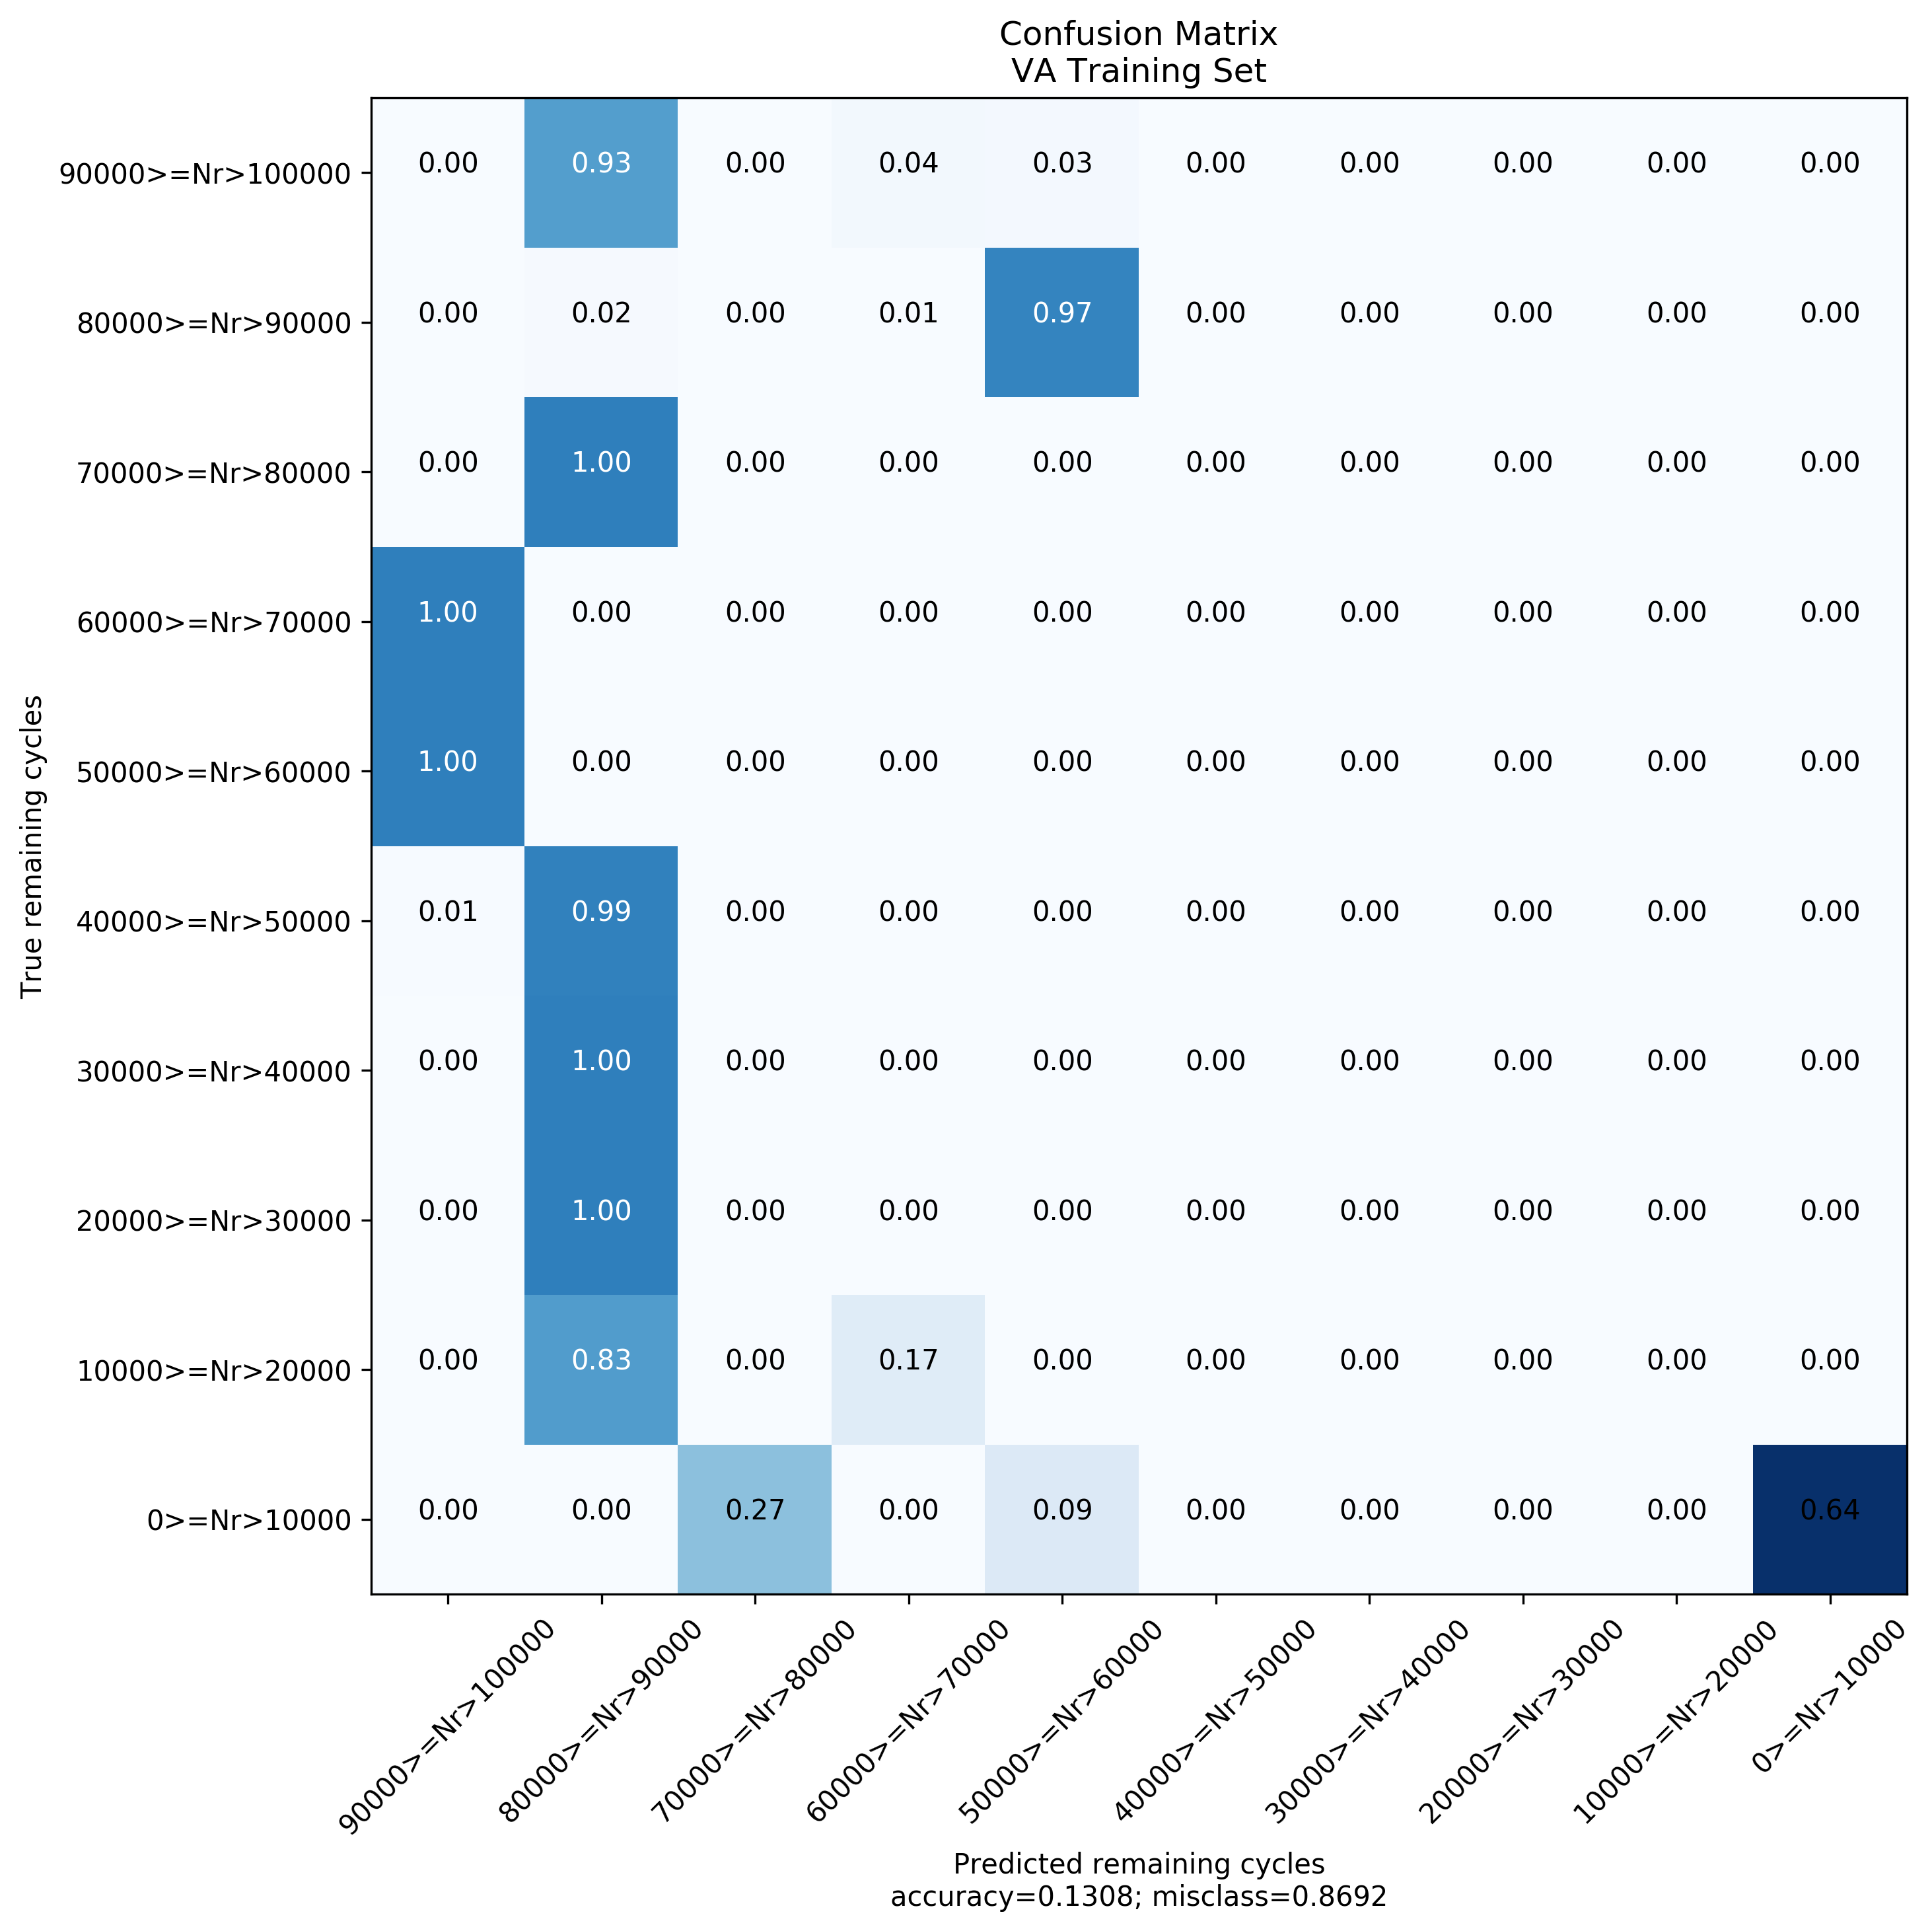

In [150]:

yyhat = model.predict(Xstrong)
cmat = confusion_matrix(np.argmax(YstrongOH,1),np.argmax(yyhat[1],1))
#cmat = cmat[0:-1,0:-1]
crange = int(150000/15);
target_names = ["%i>=Nr>%i"%((i)*crange,(i+1)*crange) for i in range(cmat.shape[0])]
plot_confusion_matrix(cmat.eval(session = keras.backend.get_session()),
                      target_names = target_names , figsize = (10,10), normalize= True, title = "Confusion Matrix\nVA Training Set")


NameError: name 'plot_confusion_matrix' is not defined